## Training the data on CNN

(90000, 6720) (6720,)


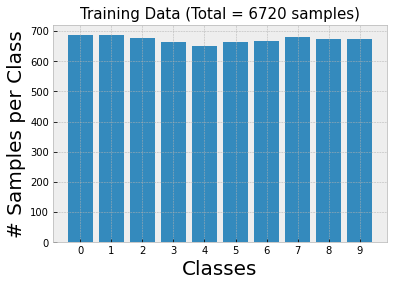

In [1]:
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop, MaxPooling2D, Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import BatchNormalization
from numpy import mean, std 
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('new_labels_train.npy')

print(data_train.shape, labels_train.shape)

# Counting number samples per class
vals, counts = np.unique(labels_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[1])+' samples)',size=15);

## Visualising some images after and before preprocessing

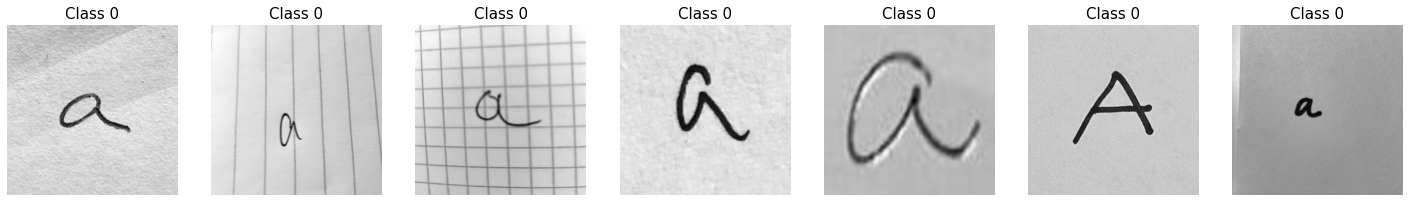

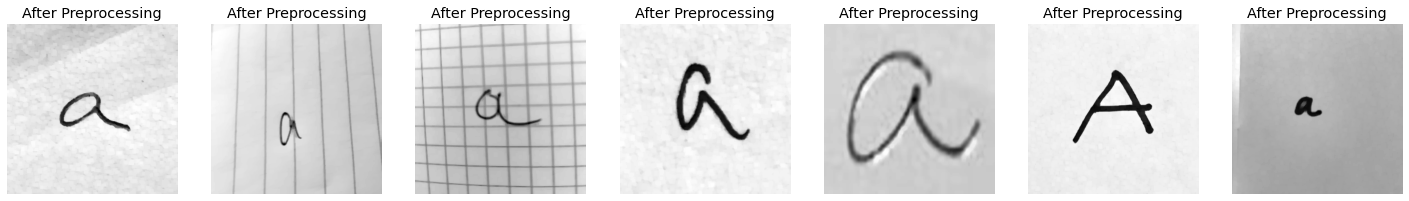

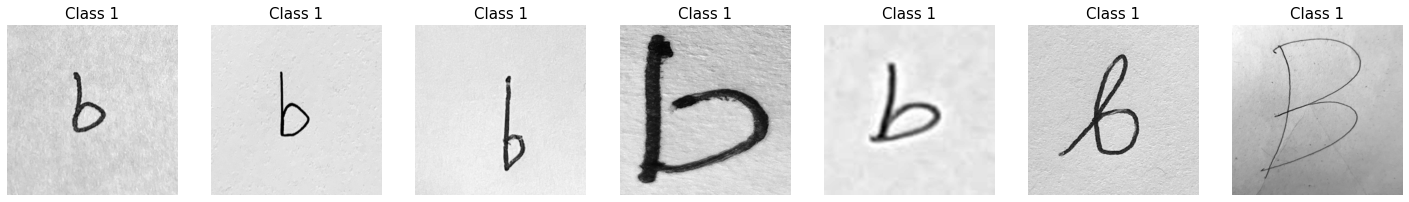

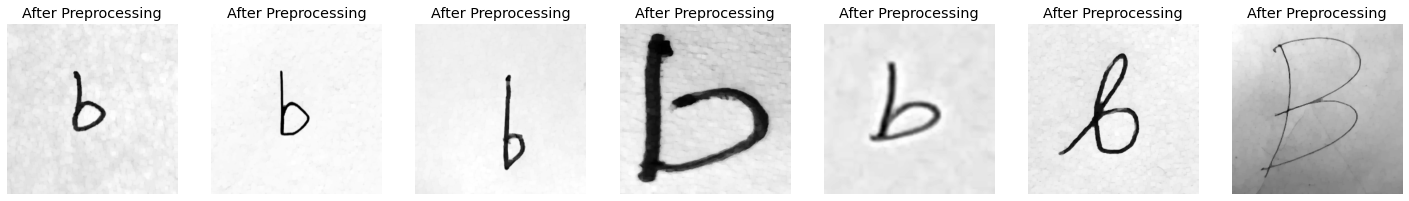

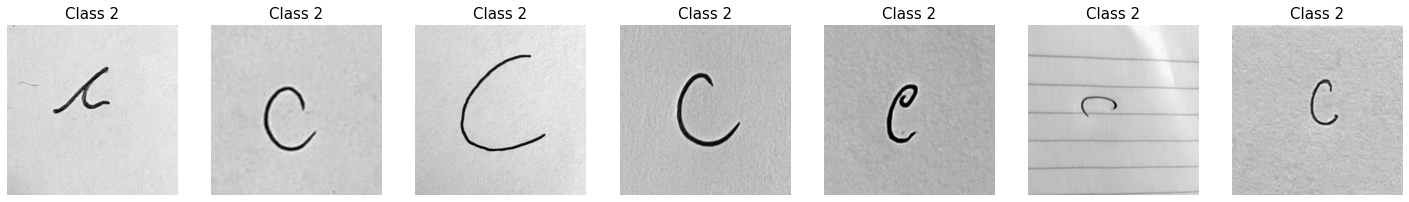

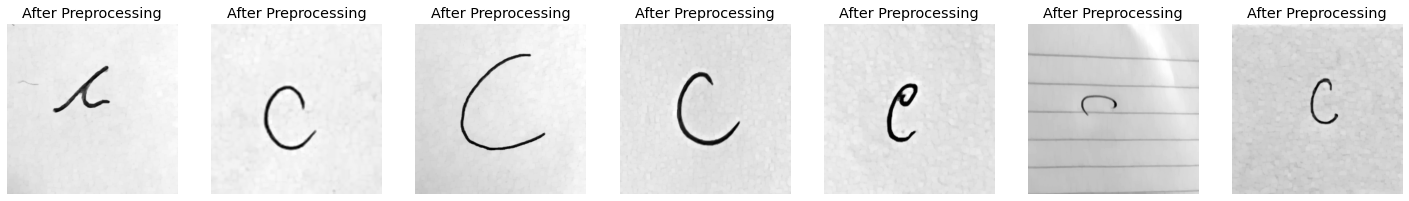

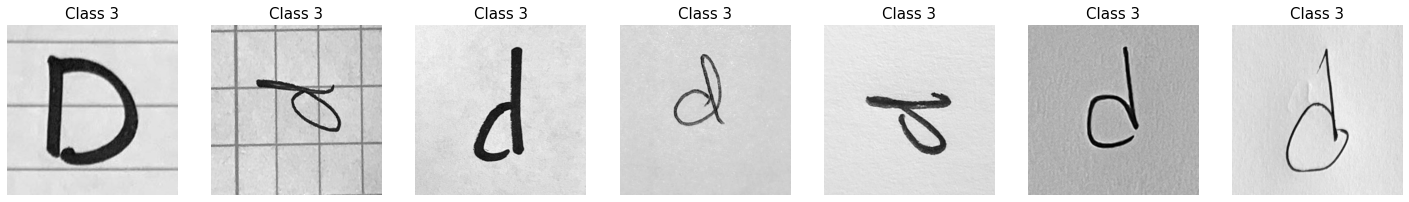

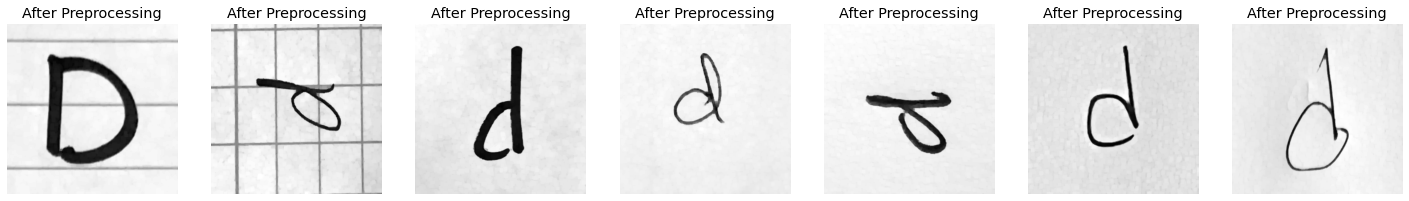

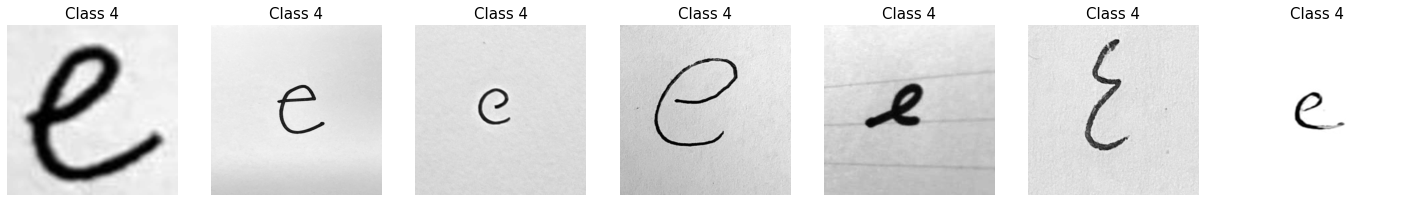

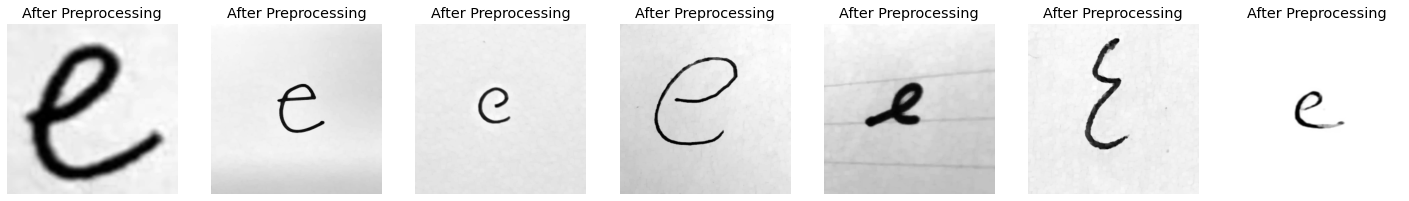

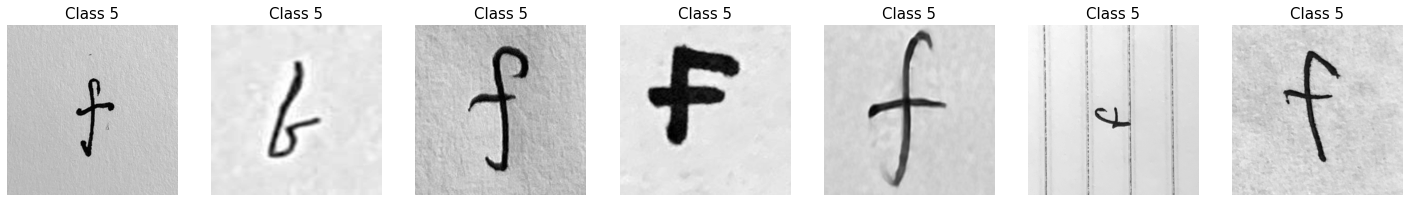

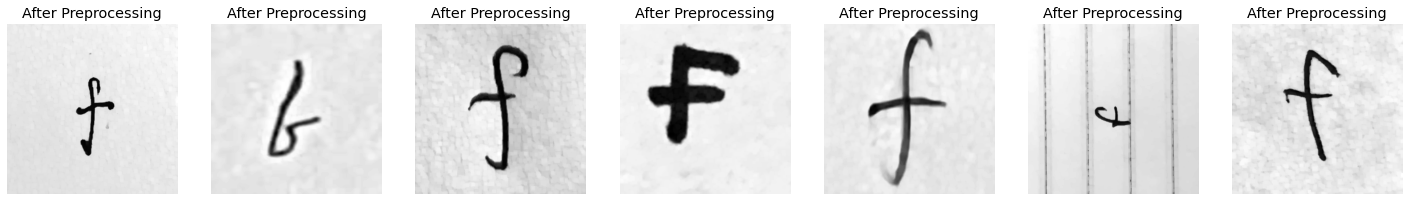

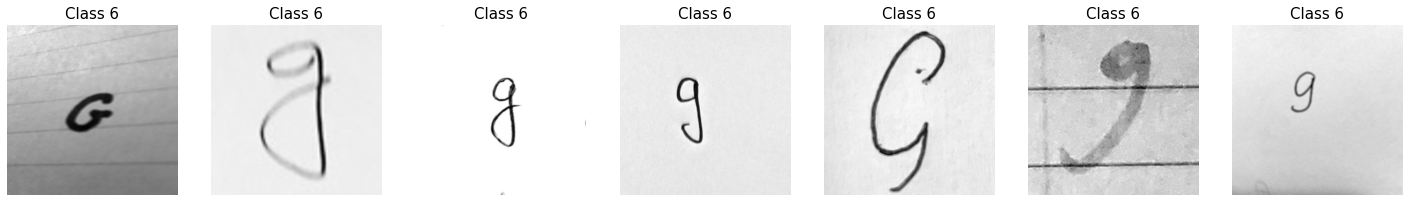

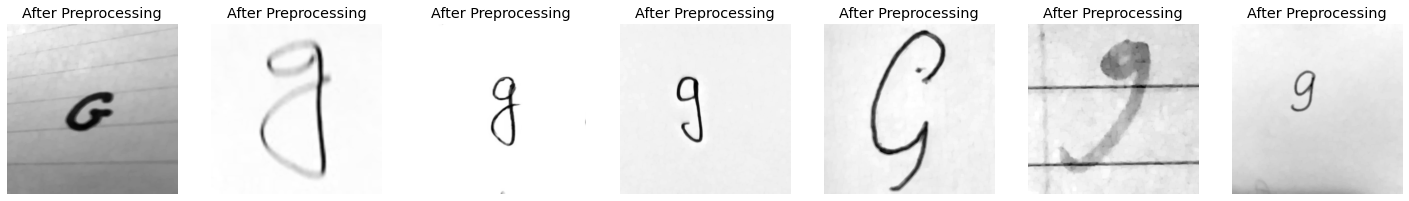

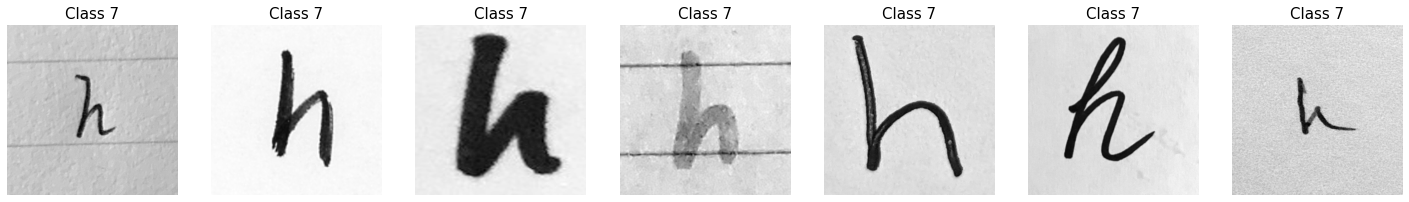

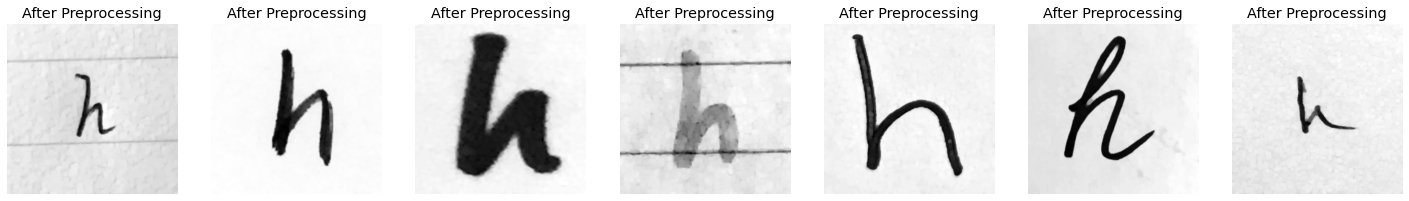

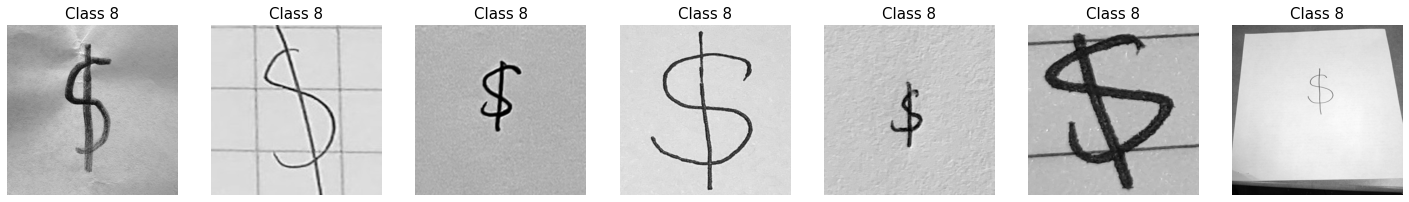

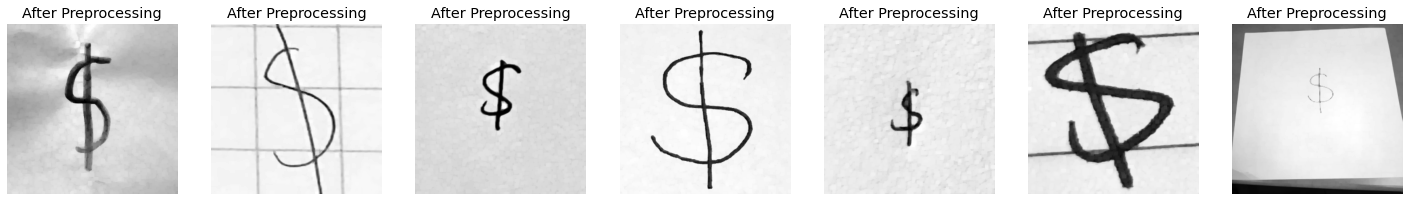

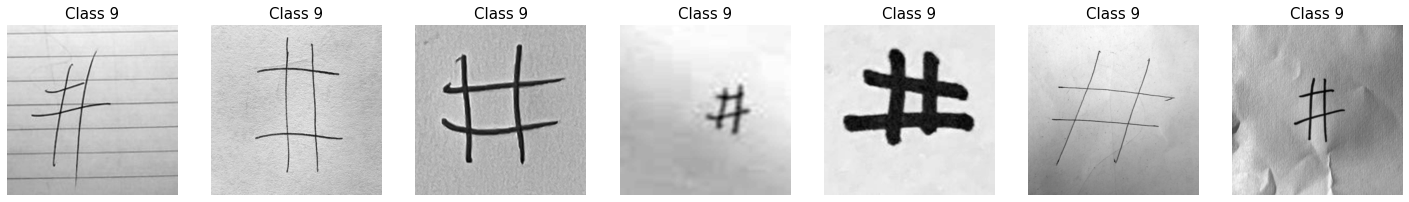

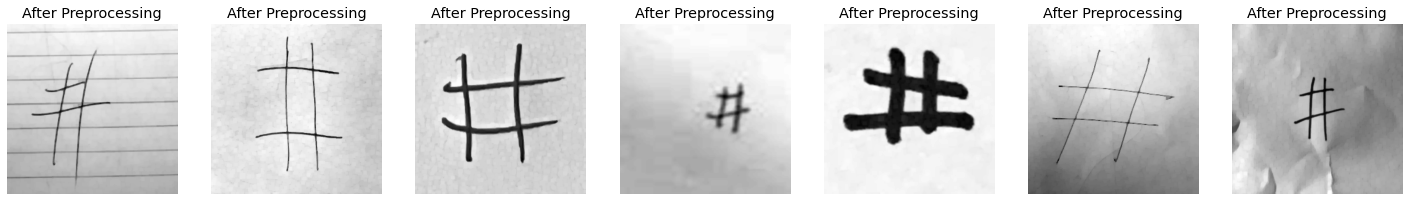

In [2]:
import cv2
kernel = np.ones((5,5),np.uint8)
for i in range(0,10):
    rnd_sample = npr.permutation(np.where(labels_train==i)[0])
    fig1=plt.figure(figsize=(25,20))
    for j in range(7):
        fig1.add_subplot(5,7,j+1)
        plt.imshow(data_train[:,rnd_sample[j]].reshape((300,300)),cmap='gray')
        plt.axis('off');plt.title('Class '+str(int(labels_train[rnd_sample[j]])),size=15)
    plt.show()
    print('\n\n')
    j = 0
    fig=plt.figure(figsize=(25,20))
    dt = []
    k=0
    for j in range(7):
        fig.add_subplot(5,7,j+1)
        dt.append(cv2.medianBlur((data_train[:,rnd_sample[j]].reshape((300,300))), 3))
        dt[j] = cv2.morphologyEx(dt[j], cv2.MORPH_OPEN, kernel)
        plt.imshow(dt[j],cmap='gray')
        k = k + 1
        plt.axis('off');plt.title('After Preprocessing')
    plt.show()
    print('\n\n')

In [3]:
import argparse
import skimage as sk
from skimage import transform
from skimage import util
import cv2
train_data_length = data_train.shape[1]
# Initial function for loading training set and preprocess dataset
def load_dataset():
    # load dataset
    data_rgb = []
    kernel = np.ones((4,4),np.uint8)
    for i in range(train_data_length):
        data_rgb.append(data_train[:,i].reshape(300,300))
        data_rgb[i] = cv2.medianBlur(data_rgb[i], 3)
        data_rgb[i] = cv2.morphologyEx(data_rgb[i], cv2.MORPH_OPEN, kernel)
        data_rgb[i] = cv2.resize(data_rgb[i], (50,50), interpolation=cv2.INTER_AREA)
    data_rgb = np.array(data_rgb)
    print(data_rgb.shape)

    # Using 80-20 split
    trainX, testX, trainY, testY = train_test_split(data_rgb, labels_train, test_size = 0.2, stratify=labels_train)
    
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 50,50, 1))
    testX = testX.reshape((testX.shape[0], 50,50, 1))
    
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY

In [4]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    # he_uniformize to range 0-1
    train_norm = (train_norm) / 255.0
    test_norm = (test_norm) / 255.0
    
    # return he_uniformized images
    return train_norm, test_norm

In [5]:
# define cnn model
def define_model(learn_rate = '0.007'):
    model = Sequential()
    model.add(RandomContrast((0,0.3),input_shape=(50,50,1)))
    model.add(RandomRotation(0.1, fill_mode='reflect', interpolation='bilinear'))
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(50,50, 1)))
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(32, (3,3),activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3,3),activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64,(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64,(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = Adam(learning_rate = learn_rate , epsilon=1e-5)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Function for Finding best parameters using GRID CV
def training(dataX, dataY, tes_X, tes_y):
    parameters = {'epochs':[800], 'batch_size':[32, 128], 'learn_rate':[0.001, 0.0007]}
    model = KerasClassifier(build_fn = define_model, epochs = 800, batch_size = 32)
    grid = GridSearchCV(estimator = model, param_grid = parameters, n_jobs = 1, cv = 3, verbose = 2, return_train_score = True)
    grid_result = grid.fit(dataX, dataY)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_estimator_

## Code for GRID Search and Best estimator in comments below, you don't have to run these 2 cells below as we know our best parameters now.

In [13]:
# def load_and_train():
#     # load dataset
#     trainX, trainY, testX, testY = load_dataset()
    
#     # prepare pixel data
#     trainX, testX = prep_pixels(trainX, testX)
    
#     # evaluate model
#     best_estimator = training(trainX, trainY, testX, testY)
#     return best_estimator
# best_estimator = load_and_train()

In [10]:
# print(best_estimator.get_params())

{'epochs': 800, 'batch_size': 32, 'learn_rate': 0.0007, 'build_fn': <function define_model at 0x2b6665dff5e0>}


### We can see from above what the best parameters are, so we will train our model now on these parameters. 

In [7]:
def final_training(dataX, dataY, testX, testY):
    model = define_model(learn_rate = 0.0007)
    print(model.summary())
    trainX, trainY, testX, testY = dataX, dataY, testX, testY
    # fit model
    history = model.fit(trainX, trainY, epochs = 800, batch_size = 32, validation_data = (testX, testY), verbose=1)
    print("Model Fitted")
    return model, history

In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    plt.figure(figsize=(12,7))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training and validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Accuracy', 'Val Accuracy'], loc='lower right')
    plt.show()
    plt.figure(figsize=(12,7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training and validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Loss', 'Val Loss'], loc='upper right')
    plt.show()

## This below cell is where we call 3 functions to split and preprocess the dataset, Normalize the images and finally train on 80% data.

In [9]:
trainX, trainY, testX, testY = load_dataset()
    
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
    
# training the model
model, history = final_training(trainX, trainY, testX, testY)

(6720, 50, 50)
(5376, 50, 50, 1) (5376, 10) (1344, 50, 50, 1) (1344, 10)


2022-04-20 13:56:29.748779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-20 13:56:30.252276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79125 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast (RandomContr (None, 50, 50, 1)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 42, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 32)        0

2022-04-20 13:56:31.266568: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/800


2022-04-20 13:56:33.352678: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-04-20 13:56:34.264488: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-04-20 13:56:34.369035: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-20 13:56:35.782709: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


168/168 [==============================] - 6s 6ms/step - loss: 3.4276 - accuracy: 0.1025 - val_loss: 2.3224 - val_accuracy: 0.1079
Epoch 2/800
168/168 [==============================] - 1s 5ms/step - loss: 2.4370 - accuracy: 0.1256 - val_loss: 2.2919 - val_accuracy: 0.1287
Epoch 3/800
168/168 [==============================] - 1s 4ms/step - loss: 2.3497 - accuracy: 0.1198 - val_loss: 2.2682 - val_accuracy: 0.1659
Epoch 4/800
168/168 [==============================] - 1s 5ms/step - loss: 2.2975 - accuracy: 0.1295 - val_loss: 2.2488 - val_accuracy: 0.1696
Epoch 5/800
168/168 [==============================] - 1s 5ms/step - loss: 2.2669 - accuracy: 0.1479 - val_loss: 2.1815 - val_accuracy: 0.1927
Epoch 6/800
168/168 [==============================] - 1s 5ms/step - loss: 2.2229 - accuracy: 0.1788 - val_loss: 2.1117 - val_accuracy: 0.2277
Epoch 7/800
168/168 [==============================] - 1s 4ms/step - loss: 2.1738 - accuracy: 0.1970 - val_loss: 2.0937 - val_accuracy: 0.2455
Epoch 8/800

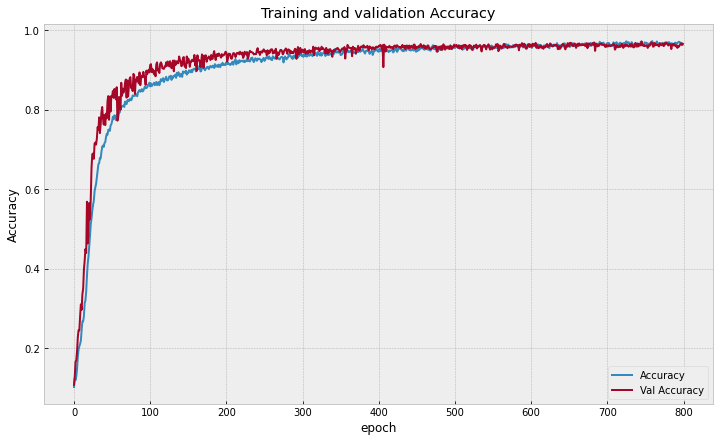

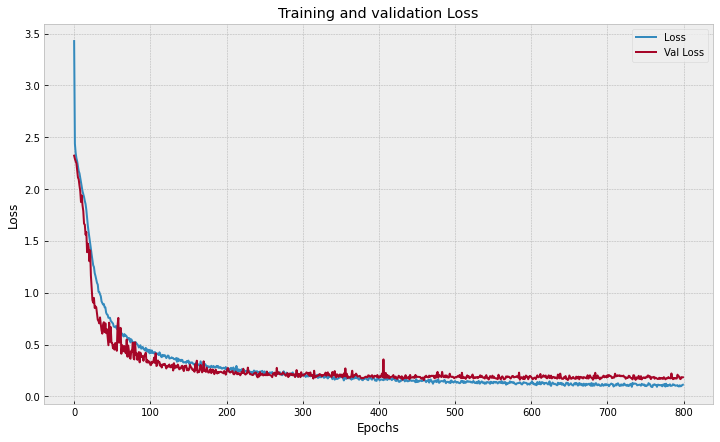

In [10]:
summarize_diagnostics(history)

We can see that we are getting a flat line around 600-800 epochs with accuracy greater than 95%, and both Validation and Training accuracy and loss are close, so there is no underfitting and overfitting, but val_loss is increasing after some 700 epochs, so we should use epochs between 600 and 700.
So, this model is good, so we can train our model with these parameters on complete data_train set.

### Below are the final functions used to Load, Preprocess amd Train our full data.

In [12]:
def final_training_complete(dataX, dataY):
    model = define_model(learn_rate = 0.0007)
    trainX, trainY = dataX, dataY
    
    # fit model
    history = model.fit(trainX, trainY, epochs = 650, batch_size = 32, verbose=0)
    print("Model Fitted")
    return model, history

In [13]:
def load_full_dataset():
    # load dataset
    data_rgb = []
    kernel = np.ones((4,4),np.uint8)
    for i in range(train_data_length):
        data_rgb.append(data_train[:,i].reshape(300,300))
        data_rgb[i] = cv2.medianBlur(data_rgb[i], 3)
        data_rgb[i] = cv2.morphologyEx(data_rgb[i], cv2.MORPH_OPEN, kernel)
        data_rgb[i] = cv2.resize(data_rgb[i], (50,50), interpolation=cv2.INTER_AREA)
    data_rgb = np.array(data_rgb)
    print(data_rgb.shape)
    
    # reshape dataset to have a single channel
    data_rgb = data_rgb.reshape((data_rgb.shape[0], 50,50, 1))
    
    # one hot encode target values
    labels = to_categorical(labels_train)
    print(data_rgb.shape, labels.shape)
    return data_rgb, labels

In [14]:
def prep_final_pixels(data):
    # convert from integers to floats
    data_norm = data.astype('float32')
    
    # he_uniformize to range 0-1
    data_norm = (data_norm) / 255.0
    
    # return he_uniformized images
    return data_norm

### In this cell all final functions are called to train our dataset on all images.

In [15]:
data, target = load_full_dataset()
    
# prepare pixel data
data = prep_final_pixels(data)
    
# training the model
model, history = final_training_complete(data, target)

(6720, 50, 50)
(6720, 50, 50, 1) (6720, 10)
Model Fitted


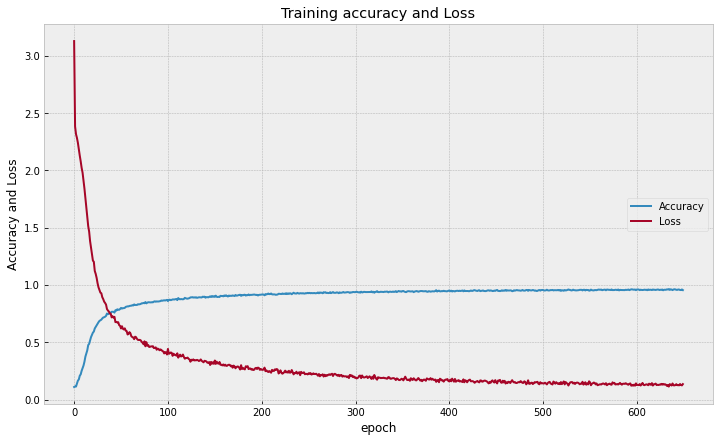

In [16]:
plt.figure(figsize=(12,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Training accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='center right')
plt.show()

In [17]:
# model.save("Final_CNN")

2022-04-20 14:16:39.478446: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Final_CNN/assets


### Finally, we saved our model as "Final_CNN" and will use this trained model in our Easy_Test and Hard_Test files.